Training class counts: Counter({'glass': 999, 'paper': 727, 'cardboard': 618, 'plastic': 591, 'metal': 525, 'trash': 525})
Test class counts: Counter({'glass': 428, 'paper': 311, 'cardboard': 264, 'plastic': 252, 'metal': 225, 'trash': 224})


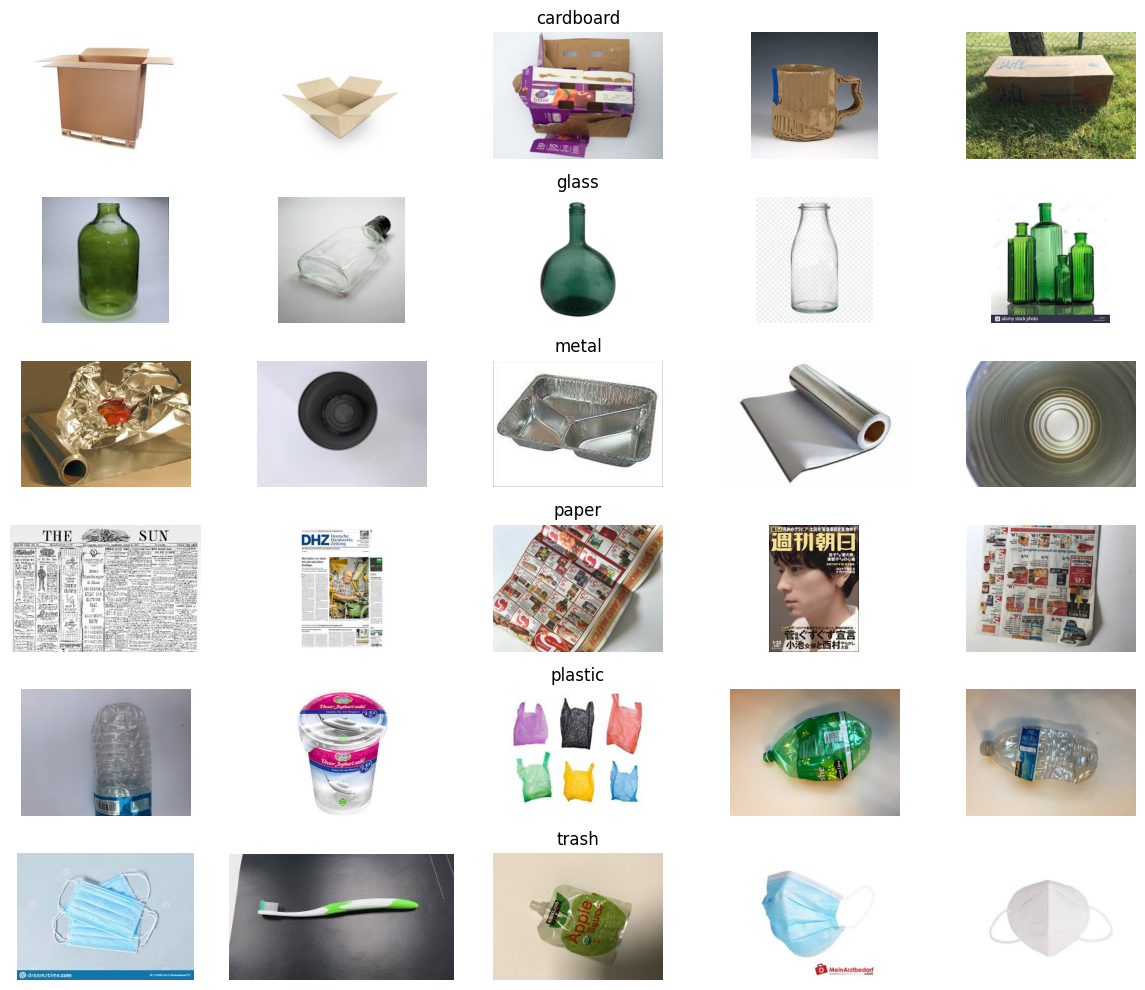

Image width range: 51 - 512
Image height range: 100 - 400


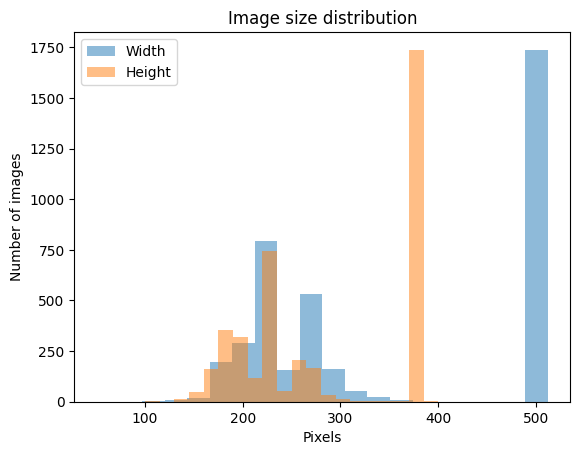

Color channels distribution: Counter({'RGB': 3973, 'P': 12})


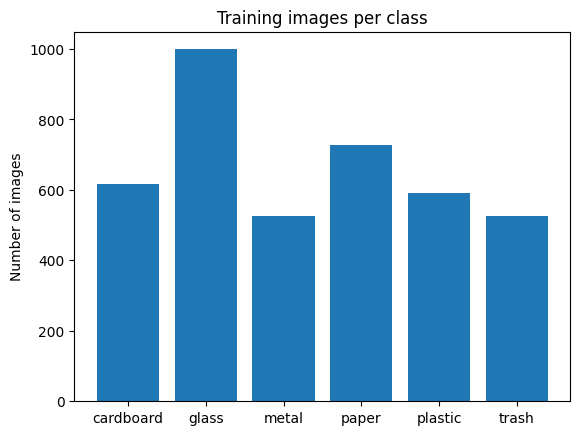

In [1]:
# EDA

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
from pathlib import Path
from PIL import Image
import random
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

data_dir = Path(os.getenv("PROJECT_DIR")) / os.getenv("DATA_DIR")
train_dir = data_dir / "train"
test_dir = data_dir / "test"

# Helper function to extract class from filename
def get_class(file_path):
    return file_path.name.split("_")[1]  # e.g., 'train_cardboard_014.jpg' -> 'cardboard'

# ----------------------------
# 1️⃣ Class counts
# ----------------------------
train_files = list(train_dir.glob("*.jpg"))
train_classes = [get_class(f) for f in train_files]
train_counts = Counter(train_classes)
print("Training class counts:", train_counts)

test_files = list(test_dir.glob("*.jpg"))
test_classes = [get_class(f) for f in test_files]
test_counts = Counter(test_classes)
print("Test class counts:", test_counts)

# ----------------------------
# 2️⃣ Sample images per class
# ----------------------------
classes = list(train_counts.keys())
fig, axes = plt.subplots(len(classes), 5, figsize=(12, 10))
for i, cls in enumerate(classes):
    cls_files = [f for f in train_files if get_class(f) == cls]
    for j, img_path in enumerate(random.sample(cls_files, min(5, len(cls_files)))):
        ax = axes[i, j]
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        if j == 2:
            ax.set_title(cls)
plt.tight_layout()
plt.show()

# ----------------------------
# 3️⃣ Image sizes
# ----------------------------
sizes = [Image.open(f).size for f in train_files]
widths, heights = zip(*sizes)
print(f"Image width range: {min(widths)} - {max(widths)}")
print(f"Image height range: {min(heights)} - {max(heights)}")

plt.hist(widths, bins=20, alpha=0.5, label="Width")
plt.hist(heights, bins=20, alpha=0.5, label="Height")
plt.xlabel("Pixels")
plt.ylabel("Number of images")
plt.title("Image size distribution")
plt.legend()
plt.show()

# ----------------------------
# 4️⃣ Color channels check
# ----------------------------
modes = [Image.open(f).mode for f in train_files]
mode_counts = Counter(modes)
print("Color channels distribution:", mode_counts)

# ----------------------------
# 5️⃣ Class distribution bar chart
# ----------------------------
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Training images per class")
plt.ylabel("Number of images")
plt.show()


In [1]:
from collections import Counter
from xml.parsers.expat import model

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, models

from config import Config
from data_manager import DataManager
from material_dataset import MaterialDataset
from train_model import TrainModel  # your class

from logger import setup_logging
import logging

def main():

    # Initialize config
    cfg = Config()

    # Setup logging
    setup_logging(level=cfg.log_level, log_file=cfg.log_file)
    logger = logging.getLogger("main")

    # Check GPU availability
    def check_gpu():
        logger.info("CUDA: %s", torch.cuda.is_available())
        if torch.cuda.is_available():
            logger.info("GPU: %s", torch.cuda.get_device_name(0))

    check_gpu()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Extract dataset
    data_manager = DataManager()
    data_manager.extract_dataset()

    # Transforms
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(12),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
        transforms.RandomGrayscale(p=0.05),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
        transforms.RandomErasing(p=0.15),
    ])

    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),  # <-- fixed H,W
        transforms.ToTensor(),
        transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
    ])

    # Files / labels
    train_files = data_manager.get_train_images_list()
    test_files  = data_manager.get_test_images_list()

    classes = data_manager.get_classes_list()
    class_to_idx = data_manager.get_class_index_map()

    train_labels = [class_to_idx[data_manager.get_class_from_filename(p)] for p in train_files]
    test_labels  = [class_to_idx[data_manager.get_class_from_filename(p)] for p in test_files]

    # Datasets
    train_dataset = MaterialDataset(
        files=train_files,
        transform=transform_train,
        classes=classes,
        class_to_idx=class_to_idx,
        labels=train_labels
    )
    test_dataset = MaterialDataset(
        files=test_files,
        transform=transform_test,
        classes=classes,
        class_to_idx=class_to_idx,
        labels=test_labels
    )

    # DataLoaders (good defaults)
    num_workers = getattr(cfg, "num_workers", 4)
    pin_memory = (device.type == "cuda")

    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.batch_size_train,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=cfg.batch_size_test,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    logger.info("Train images: %d | Test images: %d", len(train_dataset), len(test_dataset))
    logger.info("Train batches/epoch: %d", len(train_loader))
    logger.info("Classes: %s", train_dataset.classes)

    # Model
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    num_classes = len(train_dataset.classes)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, num_classes),
    )

    nn.init.kaiming_normal_(model.fc[1].weight)
    nn.init.zeros_(model.fc[1].bias)


    # Class weights
    counts = Counter(train_labels)
    weights = [1.0 / max(1, counts.get(i, 0)) for i in range(num_classes)]
    class_weights = torch.tensor(weights, dtype=torch.float, device=device)

    # Trainer
    trainer = TrainModel(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        cfg=cfg
    )

    bests = {}
    for stage in cfg.stages:
        stage_name = stage["name"]

        criterion = nn.CrossEntropyLoss(
            weight=class_weights if stage["use_class_weights"] else None,
            label_smoothing=stage["label_smoothing"],
        )

        bests[stage_name] = trainer.train_stage(
            stage_name=stage_name,
            epochs=stage["epochs"],
            lr_max=stage["lr_max"],
            wd=stage["wd"],
            criterion=criterion,
        )

    logger.info("Done. Bests: %s", bests)

    logger.info("Running final best model evals (fast flip TTA)...")

    trainer.load_model("../models/polish_best_model.pth")
    acc_flip_tta = trainer.evaluate_flip_tta(ema=None)

    trainer.load_model("../models/polish_with_ema_best_model.pth")
    acc_flip_tta = trainer.evaluate_flip_tta(ema=None)
    
    logger.info("Final flip TTA acc: %.4f", acc_flip_tta)

if __name__ == "__main__":
    main()


[14:39:02] [INFO] main: CUDA: True
[14:39:02] [INFO] main: GPU: NVIDIA GeForce RTX 3060 Ti
[14:39:02] [INFO] DataManager: Data directory set to: C:\Users\jackb\source\repos\Automated_Material_Recognition\data
[14:39:02] [INFO] DataManager: Unzipping dataset from C:\Users\jackb\source\repos\Automated_Material_Recognition\data\AI_Portfolio_Dataset.zip
[14:39:05] [WARNING] DataManager: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train already exists. It will be overwritten.
[14:39:06] [INFO] DataManager: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\train to C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train
[14:39:06] [WARNING] DataManager: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test already exists. It will be overwritten.
[14:39:06] [INFO] DataManager: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\test to C:\Users\jackb\source\repos\Au

In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from collections import Counter

from config import Config
from data_manager import DataManager
from material_dataset import MaterialDataset
from train_model import TrainModel

import torchvision.transforms.functional as F

class PadToSquare:
    def __init__(self, fill=0):
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        if w == h:
            return img
        if w > h:
            pad = (0, (w - h) // 2, 0, w - h - (w - h) // 2)  # left, top, right, bottom
        else:
            pad = ((h - w) // 2, 0, h - w - (h - w) // 2, 0)
        return F.pad(img, pad, fill=self.fill)


# -----------------------------
# 0) Device + config
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = Config()

# -----------------------------
# 1) Load dataset file lists + class mapping (same as training)
# -----------------------------
data_manager = DataManager()
data_manager.extract_dataset()

test_files = data_manager.get_test_images_list()
classes = data_manager.get_classes_list()
class_to_idx = data_manager.get_class_index_map()
test_labels = [class_to_idx[data_manager.get_class_from_filename(p)] for p in test_files]

# -----------------------------
# 2) Build a TTA-friendly test transform (NO CenterCrop)
# -----------------------------
transform_test_tta = transforms.Compose([
    transforms.Resize((256, 256)),  # <-- fixed H,W
    transforms.ToTensor(),
    transforms.Normalize(cfg.imagenet_mean, cfg.imagenet_std),
])

test_dataset_tta = MaterialDataset(
    files=test_files,
    transform=transform_test_tta,
    classes=classes,
    class_to_idx=class_to_idx,
    labels=test_labels
)

test_loader_tta = DataLoader(
    test_dataset_tta,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

# -----------------------------
# 3) Rebuild the model architecture (must match training)
# -----------------------------
num_classes = len(classes)
model = models.resnet50(weights=None)  # weights don't matter when loading your trained weights
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)

# -----------------------------
# 4) Load checkpoint weights
# -----------------------------
CKPT_PATH = "../models/archive/best_polish_9712.pt"  # <-- change this
ckpt = torch.load(CKPT_PATH, map_location=device)

# If you saved {"model": state_dict, ...}
state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state_dict)

# -----------------------------
# 5) Evaluate using your trainer's flip TTA
# -----------------------------
trainer = TrainModel(model=model, train_loader=None, test_loader=test_loader_tta, device=device, cfg=cfg)

acc_flip_tta = trainer.evaluate_flip_tta()

print(f"Flip TTA acc: {acc_flip_tta:.4f}")

[14:27:29] [INFO] DataManager: Data directory set to: C:\Users\jackb\source\repos\Automated_Material_Recognition\data
[14:27:29] [INFO] DataManager: Unzipping dataset from C:\Users\jackb\source\repos\Automated_Material_Recognition\data\AI_Portfolio_Dataset.zip
[14:27:32] [WARNING] DataManager: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train already exists. It will be overwritten.
[14:27:32] [INFO] DataManager: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\train to C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train
[14:27:32] [WARNING] DataManager: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test already exists. It will be overwritten.
[14:27:33] [INFO] DataManager: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\test to C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test
[14:27:33] [INFO] DataManager: Removing temporary da

Flip TTA acc: 0.9712
